# New York City Taxi Fare Prediction

We'll train a machine learning model to predict the fare for a taxi ride in New York city given information like pickup date & time, pickup location, drop location and no. of passengers. 

Dataset Link: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction

In [13]:
import jovian

In [14]:
!pip install numpy pandas jovian opendatasets scikit-learn xgboost --quiet

### Download Data from Kaggle

We'll use the opendatasets library: https://github.com/JovianML/opendatasets

In [15]:
import os
import opendatasets as od
import pandas as pd

In [16]:
dataset_url = 'https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview'

In [19]:
%%time
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pragyasingh03041996
Your Kaggle Key: ········


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.56G/1.56G [04:09<00:00, 6.72MB/s]



Extracting archive ./new-york-city-taxi-fare-prediction/new-york-city-taxi-fare-prediction.zip to ./new-york-city-taxi-fare-prediction
CPU times: user 29.7 s, sys: 16.4 s, total: 46.1 s
Wall time: 4min 41s


In [20]:
data_dir = './new-york-city-taxi-fare-prediction/'

In [21]:
!ls -lh {data_dir} #! tells it a shell command and it will directly run it on the system

total 11136680
-rw-r--r--  1 pragya  staff   486B Feb 26 08:30 GCP-Coupons-Instructions.rtf
-rw-r--r--  1 pragya  staff   335K Feb 26 08:30 sample_submission.csv
-rw-r--r--  1 pragya  staff   960K Feb 26 08:30 test.csv
-rw-r--r--  1 pragya  staff   5.3G Feb 26 08:30 train.csv


In [22]:
# Training set
!head {data_dir}/train.csv

In [23]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Committed successfully! https://jovian.com/pragyakiran03041996/lesson7


'https://jovian.com/pragyakiran03041996/lesson7'

In [24]:
!wc -l {data_dir}/train.csv

 55423856 ./new-york-city-taxi-fare-prediction//train.csv


In [25]:
!wc -l {data_dir}/test.csv

    9914 ./new-york-city-taxi-fare-prediction//test.csv


In [26]:
!wc -l {data_dir}/sample_submission.csv

    9915 ./new-york-city-taxi-fare-prediction//sample_submission.csv


In [27]:
!head {data_dir}/test.csv

In [28]:
!head {data_dir}/sample_submission.csv

key,fare_amount
2015-01-27 13:08:24.0000002,11.35
2015-01-27 13:08:24.0000003,11.35
2011-10-08 11:53:44.0000002,11.35
2012-12-01 21:12:12.0000002,11.35
2012-12-01 21:12:12.0000003,11.35
2012-12-01 21:12:12.0000005,11.35
2011-10-06 12:10:20.0000001,11.35
2011-10-06 12:10:20.0000003,11.35
2011-10-06 12:10:20.0000002,11.35


Observations:

- This is a supervised learning regression problem
- Training data is 5.5 GB in size
- Training data has 5.5 million rows
- Test set is much smaller (< 10,000 rows)
- The training set has 8 columns:
    - `key` (a unique identifier)
    - `fare_amount` (target column)
    - `pickup_datetime`
    - `pickup_longitude`
    - `pickup_latitude`
    - `dropoff_longitude`
    - `dropoff_latitude`
    - `passenger_count`
- The test set has all columns except the target column `fare_amount`.
- The submission file should contain the `key` and `fare_amount` for each test sample.


### Loading Training Set

Loading the entire dataset into Pandas is going to be slow, so we can use the following optimizations:

- Ignore the `key` column
- Parse pickup datetime while loading data 
- Specify data types for other columns
   - `float32` for geo coordinates
   - `float32` for fare amount
   - `uint8` for passenger count
- Work with a 1% sample of the data (~500k rows)

We can apply these optimizations while using [`pd.read_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)

In [29]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "pragyakiran03041996/lesson7" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/pragyakiran03041996/lesson7


'https://jovian.com/pragyakiran03041996/lesson7'

In [31]:
import pandas as pd
import random

In [32]:
sample_frac = 0.01

In [35]:
selected_cols ='fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count'.split(',')
selected_cols

['fare_amount',
 'pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count']

In [41]:
dtypes={
    'fare_amount' : 'float32',
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32',
    'dropoff_latitude': 'float32',
    'passenger_count': 'uint8'
}

In [43]:
def skip_rows(row_idx):
    if row_idx==0:
        return False
    
    #random.random() returns a number between 0 and 1, and is uniform. So always there is a 1 percent chance of it\
    #to return a number less than the sample frac
    return random.random() > sample_frac


random.seed(42)
df = pd.read_csv(data_dir+'/train.csv',
                usecols=selected_cols,
                dtype=dtypes,
                parse_dates=['pickup_datetime'], 
                skiprows=skip_rows)
    

In [44]:
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.0,2014-12-06 20:36:22+00:00,-73.979813,40.751904,-73.979446,40.755482,1
1,8.0,2013-01-17 17:22:00+00:00,0.000000,0.000000,0.000000,0.000000,2
2,8.9,2011-06-15 18:07:00+00:00,-73.996330,40.753223,-73.978897,40.766964,3
3,6.9,2009-12-14 12:33:00+00:00,-73.982430,40.745747,-73.982430,40.745747,1
4,7.0,2013-11-06 11:26:54+00:00,-73.959061,40.781059,-73.962059,40.768604,1
...,...,...,...,...,...,...,...
552445,45.0,2014-02-06 23:59:45+00:00,-73.973587,40.747669,-73.999916,40.602894,1
552446,22.5,2015-01-05 15:29:08+00:00,-73.935928,40.799656,-73.985710,40.726952,2
552447,4.5,2013-02-17 22:27:00+00:00,-73.992531,40.748619,-73.998436,40.740143,1
552448,14.5,2013-01-27 12:41:00+00:00,-74.012115,40.706635,-73.988724,40.756218,1


### Load Test Set

For the test set, we'll simply provide the data types.

In [46]:
test_df = pd.read_csv(data_dir+'/test.csv', dtype=dtypes, parse_dates=['pickup_datetime'])
test_df

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746140,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751637,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1
...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51+00:00,-73.968124,40.796997,-73.955643,40.780388,6
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51+00:00,-73.945511,40.803600,-73.960213,40.776371,6
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15+00:00,-73.991600,40.726608,-73.789742,40.647011,6
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19+00:00,-73.985573,40.735432,-73.939178,40.801731,6


In [47]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "pragyakiran03041996/lesson7" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/pragyakiran03041996/lesson7


'https://jovian.com/pragyakiran03041996/lesson7'

## 2. Explore the Dataset

- Basic info about training set
- Basic info about test set
- Exploratory data analysis & visualization
- Ask & answer questions

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552450 entries, 0 to 552449
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        552450 non-null  float32            
 1   pickup_datetime    552450 non-null  datetime64[ns, UTC]
 2   pickup_longitude   552450 non-null  float32            
 3   pickup_latitude    552450 non-null  float32            
 4   dropoff_longitude  552450 non-null  float32            
 5   dropoff_latitude   552450 non-null  float32            
 6   passenger_count    552450 non-null  uint8              
dtypes: datetime64[ns, UTC](1), float32(5), uint8(1)
memory usage: 15.3 MB


In [49]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,552450.000000,552450.000000,552450.000000,552450.000000,552450.000000,552450.000000
mean,11.354463,-72.288383,39.830513,-72.295395,39.854305,1.684983
std,9.810809,11.622035,8.041162,12.065184,9.226158,1.337664
min,-52.000000,-1183.362793,-3084.490234,-3356.729736,-2073.150635,0.000000
25%,6.000000,-73.992020,40.734875,-73.991425,40.733990,1.000000
50%,8.500000,-73.981819,40.752621,-73.980179,40.753101,1.000000
75%,12.500000,-73.967155,40.767036,-73.963737,40.768059,2.000000
max,499.000000,2420.209473,404.983337,2467.752686,3351.403076,208.000000


In [50]:
df['pickup_datetime'].min(), df['pickup_datetime'].max()

(Timestamp('2009-01-01 00:11:46+0000', tz='UTC'),
 Timestamp('2015-06-30 23:59:54+0000', tz='UTC'))

Observations about training data:

- 550k+ rows, as expected
- No missing data (in the sample)
- `fare_amount` ranges from $-52.0$ to $499.0$ 
- `passenger_count` ranges from 0 to 208 
- There seem to be some errors in the latitude & longitude values (not in range of -180 to 180)
- Dates range from 1st Jan 2009 to 30th June 2015
- The dataset takes up ~19 MB of space in the RAM

We may need to deal with outliers and data entry errors before we train our model.

In [51]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                9914 non-null   object             
 1   pickup_datetime    9914 non-null   datetime64[ns, UTC]
 2   pickup_longitude   9914 non-null   float32            
 3   pickup_latitude    9914 non-null   float32            
 4   dropoff_longitude  9914 non-null   float32            
 5   dropoff_latitude   9914 non-null   float32            
 6   passenger_count    9914 non-null   uint8              
dtypes: datetime64[ns, UTC](1), float32(4), object(1), uint8(1)
memory usage: 319.6+ KB


In [54]:
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.976181,40.750954,-73.974945,40.751553,1.671273
std,0.042799,0.033542,0.039093,0.035436,1.278747
min,-74.252190,40.573143,-74.263245,40.568974,1.000000
25%,-73.992500,40.736125,-73.991249,40.735253,1.000000
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000
max,-72.986534,41.709557,-72.990967,41.696682,6.000000


In [55]:
test_df['pickup_datetime'].min(), test_df['pickup_datetime'].max()

(Timestamp('2009-01-01 11:04:24+0000', tz='UTC'),
 Timestamp('2015-06-30 20:03:50+0000', tz='UTC'))

Some observations about the test set:

- 9914 rows of data
- No missing values
- No obvious data entry errors
- 1 to 6 passengers (we can limit training data to this range)
- Latitudes lie between 40 and 42
- Longitudes lie between -75 and -72
- Pickup dates range from Jan 1st 2009 to Jun  30th 2015 (same as training set)

We can use the ranges of the test set to drop outliers/invalid data from the training set.

In [56]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "pragyakiran03041996/lesson7" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/pragyakiran03041996/lesson7


'https://jovian.com/pragyakiran03041996/lesson7'

### Exploratory Data Analysis and Visualization

**Exercise**: Create graphs (histograms, line charts, bar charts, scatter plots, box plots, geo maps etc.) to study the distrubtion of values in each column, and the relationship of each input column to the target.


### Ask & Answer Questions

**Exercise**: Ask & answer questions about the dataset: 

1. What is the busiest day of the week?
2. What is the busiest time of the day?
3. In which month are fares the highest?
4. Which pickup locations have the highest fares?
5. Which drop locations have the highest fares?
6. What is the average ride distance?

EDA + asking questions will help you develop a deeper understand of the data and give you ideas for feature engineering.

## 3. Prepare Dataset for Training

- Split Training & Validation Set
- Fill/Remove Missing Values
- Extract Inputs & Outputs
   - Training
   - Validation
   - Test

### Split Training & Validation Set

We'll set aside 20% of the training data as the validation set, to evaluate the models we train on previously unseen data. 

Since the test set and training set have the same date ranges, we can pick a random 20% fraction.

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [62]:
len(train_df), len(val_df)

(441960, 110490)

### Fill/Remove Missing Values

There are no missing values in our sample, but if there were, we could simply drop the rows with missing values instead of trying to fill them (since we have a lot of training data)>

In [63]:
train_df = train_df.dropna()
val_df = val_df.dropna()

### Extract Inputs and Outputs

In [64]:
df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [65]:
input_cols = ['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count']

In [66]:
target_col = 'fare_amount'

In [80]:
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]


In [68]:
val_inputs = val_df[input_cols]
val_targets = val_df[target_col]


#### Test

In [69]:
test_inputs = test_df[input_cols]

In [70]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "pragyakiran03041996/lesson7" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/pragyakiran03041996/lesson7


'https://jovian.com/pragyakiran03041996/lesson7'

## 4. Train Hardcoded & Baseline Models

- Hardcoded model: always predict average fare
- Baseline model: Linear regression 

For evaluation the dataset uses RMSE error: 
https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview/evaluation

### Train & Evaluate Hardcoded Model

Let's create a simple model that always predicts the average.

In [71]:
import numpy as np

In [73]:
class MeanRegressor:
    def fit(self, inputs, targets):
        self.mean = targets.mean()
        
    def predict(self, inputs):
        return np.full(inputs.shape[0], self.mean)

In [74]:
np.full(10, 3)

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [77]:
train_df.shape

(441960, 7)

In [78]:
mean_model = MeanRegressor()

In [81]:
mean_model.fit(train_inputs, train_targets)

In [82]:
mean_model.mean

11.354591369628906

In [83]:
train_preds = mean_model.predict(train_targets)

In [84]:
train_preds

array([11.35459137, 11.35459137, 11.35459137, ..., 11.35459137,
       11.35459137, 11.35459137])

In [86]:
val_preds = mean_model.predict(val_inputs)
val_preds

array([11.35459137, 11.35459137, 11.35459137, ..., 11.35459137,
       11.35459137, 11.35459137])

In [87]:
train_targets

353352     6.0
360070     3.7
372609    10.0
550895     8.9
444151     7.3
          ... 
110268     9.3
259178    18.5
365838    10.1
131932    10.9
121958     9.5
Name: fare_amount, Length: 441960, dtype: float32

In [88]:
from sklearn.metrics import root_mean_squared_error

In [89]:
def rmse(targets, preds):
    return root_mean_squared_error(targets, preds)

In [92]:
train_rmse = rmse(train_targets, train_preds)
train_rmse

9.78978199423857

In [93]:
val_rmse = rmse(val_targets, val_preds)
val_rmse

9.899954151552434

Our dumb hard-coded model is off by $\$9.899$ on average, which is pretty bad considering the average fare is $\$11.35$.

In [94]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "pragyakiran03041996/lesson7" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/pragyakiran03041996/lesson7


'https://jovian.com/pragyakiran03041996/lesson7'

### Train & Evaluate Baseline Model

We'll train a linear regression model as our baseline, which tries to express the target as a weighted sum of the inputs.

In [96]:
from sklearn.linear_model import LinearRegression

In [97]:
linreg_model = LinearRegression()

In [98]:
linreg_model.fit(train_inputs, train_targets)

LinearRegression()

In [100]:
train_preds = linreg_model.predict(train_inputs)
train_preds

array([11.545596, 11.284796, 11.284326, ..., 11.458551, 11.284466,
       11.284634], dtype=float32)

In [102]:
train_rmse = rmse(train_targets, train_preds)
train_rmse

9.788632

In [104]:
val_rmse = rmse(val_targets, linreg_model.predict(val_inputs))
val_rmse

9.898088

The linear regression model is off by $9.898, which isn't much better than simply predicting the average. 

This is mainly because the training data (geocoordinates) is not in a format that's useful for the model, and we're not using one of the most important columns: pickup date & time.

However, now we have a baseline that our other models should ideally beat.

## 5. Make Predictions and Submit to Kaggle

- Make predictions for test set
- Generate submissions CSV
- Submit to Kaggle
- Record in experiment tracking sheet

In [105]:
test_preds = linreg_model.predict(test_inputs)

In [106]:
submission_df = pd.read_csv(data_dir+'/sample_submission.csv')

In [108]:
submission_df['fare_amount'] = test_preds
submission_df

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.284466
1,2015-01-27 13:08:24.0000003,11.284820
2,2011-10-08 11:53:44.0000002,11.284570
3,2012-12-01 21:12:12.0000002,11.284408
4,2012-12-01 21:12:12.0000003,11.284235
...,...,...
9909,2015-05-10 12:37:51.0000002,11.719085
9910,2015-01-12 17:05:51.0000001,11.719033
9911,2015-04-19 20:44:15.0000001,11.720057
9912,2015-01-31 01:05:19.0000005,11.719606


In [109]:
submission_df.to_csv('taxi_linear_model_sub.csv', index=None)

In [111]:
def predict_and_submit(model, test_inputs, fname):
    test_preds = model.predict(test_inputs)
    sub_df = pd.read_csv(data_dir+'/sample_submission.csv')
    sub_df['fare_amount'] = test_preds
    sub_df.to_csv(fname, index=None)
    return sub_df

## 6. Feature Engineering


- Extract parts of date
- Remove outliers & invalid data
- Add distance between pickup & drop
- Add distance from landmarks

Exercise: We're going to apply all of the above together, but you should observer the effect of adding each feature individually.
### Extract Parts of Date

- Year
- Month
- Day
- Weekday
- Hour


In [112]:
def add_dateparts(df, col):
    df[col + '_year'] = df[col].dt.year
    df[col + '_month'] = df[col].dt.month
    df[col + '_day'] = df[col].dt.day
    df[col + '_weekday'] = df[col].dt.weekday
    df[col + '_hour'] = df[col].dt.hour

In [113]:
add_dateparts(train_df, 'pickup_datetime')

In [114]:
add_dateparts(val_df, 'pickup_datetime')

In [115]:
add_dateparts(test_df, 'pickup_datetime')

In [116]:
train_df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour
353352,6.0,2015-04-12 03:40:38+00:00,-73.993652,40.741543,-73.977974,40.742352,4,2015,4,12,6,3
360070,3.7,2011-01-26 19:21:00+00:00,-73.993805,40.724579,-73.993805,40.724579,1,2011,1,26,2,19
372609,10.0,2012-10-03 10:40:17+00:00,-73.959160,40.780750,-73.969116,40.761230,1,2012,10,3,2,10
550895,8.9,2012-03-14 13:44:27+00:00,-73.952187,40.783951,-73.978645,40.772602,1,2012,3,14,2,13
444151,7.3,2012-02-05 15:33:00+00:00,-73.977112,40.746834,-73.991104,40.750404,2,2012,2,5,6,15
...,...,...,...,...,...,...,...,...,...,...,...,...
110268,9.3,2009-09-06 16:12:00+00:00,-73.987152,40.750633,-73.979073,40.763168,1,2009,9,6,6,16
259178,18.5,2009-04-12 09:58:56+00:00,-73.972656,40.764042,-74.013176,40.707840,2,2009,4,12,6,9
365838,10.1,2012-07-12 19:30:00+00:00,-73.991982,40.749767,-73.989845,40.720551,3,2012,7,12,3,19
131932,10.9,2011-02-17 18:33:00+00:00,-73.969055,40.761398,-73.990814,40.751328,1,2011,2,17,3,18


In [117]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "pragyakiran03041996/lesson7" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/pragyakiran03041996/lesson7


'https://jovian.com/pragyakiran03041996/lesson7'

<AxesSubplot:title={'center':'Fare Amount vs Pickup-Hour'}, xlabel='pickup_datetime_hour', ylabel='fare_amount'>

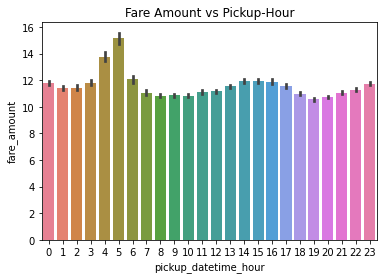

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

plt.title('Fare Amount vs Pickup-Hour')
sns.barplot(train_df, x='pickup_datetime_hour', y='fare_amount', palette='husl')

<AxesSubplot:title={'center':'Fare Amount vs Pickup-Month'}, xlabel='pickup_datetime_month', ylabel='fare_amount'>

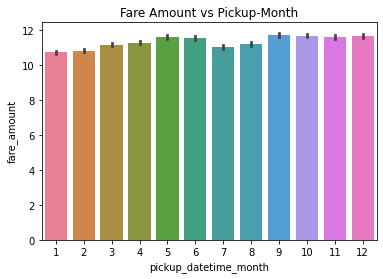

In [127]:
plt.title('Fare Amount vs Pickup-Month')
sns.barplot(train_df, x='pickup_datetime_month', y='fare_amount', palette='husl')

<AxesSubplot:title={'center':'Fare Amount vs Pickup-Weekday'}, xlabel='pickup_datetime_weekday', ylabel='fare_amount'>

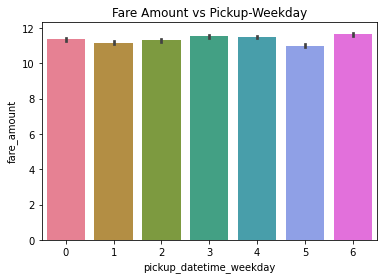

In [128]:
plt.title('Fare Amount vs Pickup-Weekday')
sns.barplot(train_df, x='pickup_datetime_weekday', y='fare_amount', palette='husl')

### Add Distance Between Pickup and Drop

We can use the haversine distance: 
- https://en.wikipedia.org/wiki/Haversine_formula
- https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas

In [129]:
import numpy as np

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [130]:
def add_trip_distance(df):
    df['trip_distance'] = haversine_np(df['pickup_longitude'],
                                       df['pickup_latitude'],
                                       df['dropoff_longitude'], 
                                       df['dropoff_latitude'])

In [131]:
%%time
add_trip_distance(train_df)
add_trip_distance(val_df)
add_trip_distance(test_df)

CPU times: user 17.5 ms, sys: 14.2 ms, total: 31.7 ms
Wall time: 32.2 ms


In [155]:
# train_df[train_df['trip_distance']>100]
train_df.sample(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance
123260,17.0,2013-03-09 03:50:45+00:00,-73.987526,40.724300,-73.935959,40.795204,1,2013,3,9,5,3,8.995722
515315,8.9,2009-08-13 22:44:30+00:00,-73.984886,40.768421,-73.987183,40.744701,1,2009,8,13,3,22,2.643137
274804,4.5,2011-10-20 06:38:00+00:00,-73.990349,40.756290,-73.976631,40.756775,1,2011,10,20,3,6,1.155736
457644,12.9,2009-12-05 01:54:00+00:00,-74.005280,40.740543,-73.975792,40.789146,1,2009,12,5,5,1,5.943952
427020,13.7,2010-07-22 02:43:00+00:00,-73.998367,40.760914,-73.922615,40.743416,1,2010,7,22,3,2,6.666853


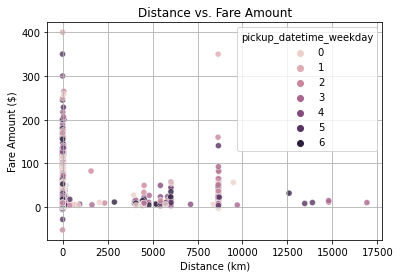

In [151]:
sns.scatterplot(x=train_df.trip_distance, y=train_df.fare_amount, hue=train_df.pickup_datetime_weekday, alpha=0.8)
plt.title('Distance vs. Fare Amount')
plt.xlabel('Distance (km)')
plt.ylabel('Fare Amount ($)')
plt.grid(True)
plt.show()

### Add Distance From Popular Landmarks

- JFK Airport
- LGA Airport
- EWR Airport
- Times Square
- Met Meuseum
- World Trade Center

We'll add the distance from drop location. 

In [156]:
jfk_lonlat = -73.7781, 40.6413
lga_lonlat = -73.8740, 40.7769
ewr_lonlat = -74.1745, 40.6895
met_lonlat = -73.9632, 40.7794
wtc_lonlat = -74.0099, 40.7126

In [157]:
def add_landmark_dropoff_distance(df, landmark_name, landmark_lonlat):
    lon, lat = landmark_lonlat
    df[landmark_name+'_drop_distance'] = haversine_np(lon, lat, df['dropoff_longitude'], df['dropoff_latitude'])


In [158]:
for a_df in [train_df, val_df, test_df]:
    for name, lonlat in [('jfk', jfk_lonlat),('lga', lga_lonlat), ('ewr', ewr_lonlat), ('met', met_lonlat)\
                         , ('wtc', wtc_lonlat)]:
        add_landmark_dropoff_distance(a_df, name, lonlat)

In [159]:
train_df.sample(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
12631,8.900000,2012-01-04 12:46:22+00:00,-73.978127,40.761154,-73.964226,40.770470,1,2012,1,4,2,12,1.561906,21.257589,7.626544,19.862034,0.996138,7.492754
427125,10.500000,2010-09-21 09:46:53+00:00,-74.009476,40.706505,-73.999290,40.733971,1,2010,9,21,1,9,3.170714,21.293941,11.574991,15.564255,5.891482,2.537587
36213,19.299999,2011-03-30 08:35:22+00:00,-73.939972,40.751366,-74.009491,40.703724,1,2011,3,30,2,8,7.893020,20.699375,14.009359,13.992039,9.268578,0.986932
13445,6.900000,2010-12-03 15:24:44+00:00,-73.976967,40.787430,-73.957710,40.779446,1,2010,12,3,4,15,1.847154,21.554111,7.049851,20.811972,0.462123,8.630554
219299,5.500000,2012-11-17 00:58:51+00:00,-73.983582,40.758778,-73.982796,40.758999,1,2012,11,17,5,0,0.070568,21.644016,9.369606,17.897409,2.802886,5.638967


### Remove Outliers and Invalid Data

There seems to be some invalide data in each of the following columns:

- Fare amount
- Passenger count
- Pickup latitude & longitude
- Drop latitude & longitude

In [160]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
count,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000
mean,11.354591,-72.521378,39.993584,-72.531738,40.021133,1.684444,2011.740038,6.263920,15.732492,3.035813,13.506568,19.751778,193.336624,182.252625,191.307755,177.326828,178.884659
std,9.788187,11.826187,8.449581,12.422503,9.833958,1.344170,1.857024,3.434881,8.697374,1.950033,6.517710,370.978485,1222.565186,1225.509888,1227.219604,1227.147827,1227.168091
min,-52.000000,-1183.362793,-3084.490234,-3356.729736,-2073.150635,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.305583,0.116402,0.129245,0.031195,0.009281
25%,6.000000,-73.992027,40.734859,-73.991409,40.733967,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000,1.212447,20.535247,8.350981,16.502820,2.169769,3.642480
50%,8.500000,-73.981819,40.752613,-73.980171,40.753078,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000,2.116254,21.202131,9.575539,18.016346,3.817937,5.559632
75%,12.500000,-73.967186,40.767006,-73.963715,40.768044,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000,3.879624,21.948318,11.122054,19.953297,6.071617,7.814558
max,400.000000,2420.209473,404.899994,2467.752686,3351.403076,208.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,16913.429688,15057.673828,15074.642578,15074.713867,15077.615234,15072.110352


In [161]:
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.976181,40.750954,-73.974945,40.751553,1.671273,2011.815816,6.857979,16.194170,2.852834,13.467420,3.433212,20.916758,9.675153,18.546644,4.512908,6.037651
std,0.042799,0.033542,0.039093,0.035436,1.278747,1.803347,3.353272,8.838482,1.994451,6.868584,3.969877,3.303940,3.295646,4.035816,4.018422,4.252535
min,-74.252190,40.573143,-74.263245,40.568974,1.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.401900,0.285629,0.284680,0.085747,0.040269
25%,-73.992500,40.736125,-73.991249,40.735253,1.000000,2010.000000,4.000000,9.000000,1.000000,8.000000,1.297261,20.513337,8.311565,16.520517,2.126287,3.670107
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000,2012.000000,7.000000,16.000000,3.000000,15.000000,2.215648,21.181472,9.477797,18.024350,3.698123,5.541466
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000,2014.000000,10.000000,25.000000,5.000000,19.000000,4.043051,21.909794,10.965272,19.880536,5.922544,7.757612
max,-72.986534,41.709557,-72.990967,41.696682,6.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,99.933281,134.497726,126.062576,149.400787,130.347153,138.619492


We'll use the following ranges:

- `fare_amount`: $\$1$ to $\$500$
- `longitudes`: -75 to -72
- `latitudes`: 40 to 42
- `passenger_count`: 1 to 6

In [162]:
def remove_outliers(df):
    return df[(df['fare_amount'] >= 1.) & 
              (df['fare_amount'] <= 500.) &
              (df['pickup_longitude'] >= -75) & 
              (df['pickup_longitude'] <= -72) & 
              (df['dropoff_longitude'] >= -75) & 
              (df['dropoff_longitude'] <= -72) & 
              (df['pickup_latitude'] >= 40) & 
              (df['pickup_latitude'] <= 42) & 
              (df['dropoff_latitude'] >=40) & 
              (df['dropoff_latitude'] <= 42) & 
              (df['passenger_count'] >= 1) & 
              (df['passenger_count'] <= 6)]

In [163]:
train_df = remove_outliers(train_df)
val_df = remove_outliers(val_df)

### Scaling and One-Hot Encoding

**Exercise**: Try scaling numeric columns to the `(0,1)` range and encoding categorical columns using a one-hot encoder.

We won't do this because we'll be training tree-based models which are generally able to do a good job even without the above.

### Save Intermediate DataFrames

Let's save the processed datasets in the Apache Parquet format, so that we can load them back easily to resume our work from this point.

You may also want to create differnt notebooks for EDA, feature engineering and model training.

In [164]:
train_df.to_parquet('train.parquet')

In [165]:
val_df.to_parquet('val.parquet')
test_df.to_parquet('test.parquet')

In [166]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "pragyakiran03041996/lesson7" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/pragyakiran03041996/lesson7


'https://jovian.com/pragyakiran03041996/lesson7'

## 7. Train & Evaluate Different Models

We'll train each of the following & submit predictions to Kaggle:

- Linear Regression
- Random Forests
- Gradient Boosting

Exercise: Train Ridge, SVM, KNN, Decision Tree models

In [168]:
train_df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_datetime_year', 'pickup_datetime_month', 'pickup_datetime_day',
       'pickup_datetime_weekday', 'pickup_datetime_hour', 'trip_distance',
       'jfk_drop_distance', 'lga_drop_distance', 'ewr_drop_distance',
       'met_drop_distance', 'wtc_drop_distance'],
      dtype='object')

In [169]:
input_cols = ['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_datetime_year', 'pickup_datetime_month', 'pickup_datetime_day',
       'pickup_datetime_weekday', 'pickup_datetime_hour', 'trip_distance',
       'jfk_drop_distance', 'lga_drop_distance', 'ewr_drop_distance',
       'met_drop_distance', 'wtc_drop_distance']

In [170]:
target_col = 'fare_amount'

In [171]:
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]

val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

test_inputs = test_df[input_cols]


Let's define a helper function to evaluate models and generate test predictions

In [180]:
def evaluate(model):
    train_preds = model.predict(train_inputs)
    train_rmse = rmse(train_targets, train_preds)
    
    val_preds = model.predict(val_inputs)
    val_rmse = rmse(val_targets, val_preds)
    
    return train_rmse, val_rmse, train_preds, val_preds

### Ridge Regression


In [173]:
from sklearn.linear_model import Ridge

In [174]:
model1 = Ridge(random_state=42)

In [175]:
model1.fit(train_inputs, train_targets)

Ridge(random_state=42)

In [181]:
evaluate(model1)

(5.049315152711234,
 5.2178656573394955,
 array([ 8.12925918,  4.11578439,  8.75063014, ..., 10.47234932,
         8.2305928 , 10.58672774]),
 array([10.91955339,  6.20493172, 46.21787888, ...,  8.0463052 ,
        25.56885585,  8.45342102]))

In [184]:
predict_and_submit(model1, test_inputs, 'ridge_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.082151
1,2015-01-27 13:08:24.0000003,11.399499
2,2011-10-08 11:53:44.0000002,5.356923
3,2012-12-01 21:12:12.0000002,8.763571
4,2012-12-01 21:12:12.0000003,14.609918
...,...,...
9909,2015-05-10 12:37:51.0000002,9.024995
9910,2015-01-12 17:05:51.0000001,11.218598
9911,2015-04-19 20:44:15.0000001,47.926481
9912,2015-01-31 01:05:19.0000005,22.600022


In [185]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "pragyakiran03041996/lesson7" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/pragyakiran03041996/lesson7


'https://jovian.com/pragyakiran03041996/lesson7'

### Random Forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [186]:
from sklearn.ensemble import RandomForestRegressor

In [187]:
model2 = RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=42, n_estimators=50)

In [188]:
%%time
model2.fit(train_inputs, train_targets)

CPU times: user 3min 43s, sys: 811 ms, total: 3min 44s
Wall time: 32.4 s


RandomForestRegressor(max_depth=10, n_estimators=50, n_jobs=-1, random_state=42)

In [189]:
evaluate(model2)

(3.6022913838561528,
 4.167257655248953,
 array([ 7.06907907,  9.09651906,  9.09834234, ..., 10.39574834,
         7.73362485, 10.36404777]),
 array([12.53923917,  6.14414213, 47.3274893 , ...,  8.32839336,
        29.20883778,  8.27729971]))

In [190]:
predict_and_submit(model2, test_inputs, 'randomforest_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.522156
1,2015-01-27 13:08:24.0000003,10.499965
2,2011-10-08 11:53:44.0000002,5.049496
3,2012-12-01 21:12:12.0000002,8.486169
4,2012-12-01 21:12:12.0000003,14.316837
...,...,...
9909,2015-05-10 12:37:51.0000002,8.873896
9910,2015-01-12 17:05:51.0000001,12.551152
9911,2015-04-19 20:44:15.0000001,55.266349
9912,2015-01-31 01:05:19.0000005,21.518925


This puts us at position 573 out of 1483 i.e. top 40%, which is already a really good score.

Remember that we're only using 1% of the data, and we haven't done much hyperparameter tuning yet.

### Gradient Boosting

https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

In [192]:
from xgboost import XGBRegressor

In [193]:
model3 = XGBRegressor(random_state =42, n_jobs=-1, objective='reg:squarederror', n_estimators=150)

In [194]:
model3.fit(train_inputs, train_targets)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [195]:
evaluate(model3)

(3.0142148,
 3.976383,
 array([ 6.6507936,  8.575949 , 10.350919 , ..., 12.2948065,  9.492498 ,
         9.795799 ], dtype=float32),
 array([15.117502 ,  5.847732 , 47.39968  , ...,  7.6203947, 30.602848 ,
         8.584382 ], dtype=float32))

In [196]:
predict_and_submit(model3, test_inputs, 'gradientboost_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.837819
1,2015-01-27 13:08:24.0000003,11.676919
2,2011-10-08 11:53:44.0000002,4.408793
3,2012-12-01 21:12:12.0000002,9.102857
4,2012-12-01 21:12:12.0000003,16.051310
...,...,...
9909,2015-05-10 12:37:51.0000002,9.345723
9910,2015-01-12 17:05:51.0000001,11.591251
9911,2015-04-19 20:44:15.0000001,53.482800
9912,2015-01-31 01:05:19.0000005,18.974161


In [198]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "pragyakiran03041996/lesson7" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/pragyakiran03041996/lesson7


'https://jovian.com/pragyakiran03041996/lesson7'

## 8. Tune Hyperparmeters

https://towardsdatascience.com/mastering-xgboost-2eb6bce6bc76


We'll train parameters for the XGBoost model. Here’s a strategy for tuning hyperparameters:

- Tune the most important/impactful hyperparameter first e.g. n_estimators

- With the best value of the first hyperparameter, tune the next most impactful hyperparameter

- And so on, keep training the next most impactful parameters with the best values for previous parameters...

- Then, go back to the top and further tune each parameter again for further marginal gains

- Hyperparameter tuning is more art than science, unfortunately. Try to get a feel for how the parameters interact with each other based on your understanding of the parameter…

Let's define a helper function for trying different hyperparameters.

In [199]:
def test_params(ModelClass, **params):
    model = ModelClass(**params).fit(train_inputs, train_targets)
    train_rmse = rmse(model.predict(train_inputs), train_targets)
    val_rmse = rmse(model.predict(val_inputs), val_targets)
    return train_rmse, val_rmse


In [204]:
def test_param_and_plot(ModelClass, param_name, param_values, **other_params):
    
    train_errors, val_errors = [],[]
    for value in param_values:
        #copying the content of other_params dictionary to params and then adding other param_name to params
        params = dict(other_params)
        params[param_name] = value
        train_rmse, val_rmse = test_params(ModelClass, **params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

In [207]:
best_params = {
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'reg:squarederror',
    'learning_rate':0.05
}


### No. of Trees

CPU times: user 45.3 s, sys: 14.8 s, total: 1min
Wall time: 9.15 s


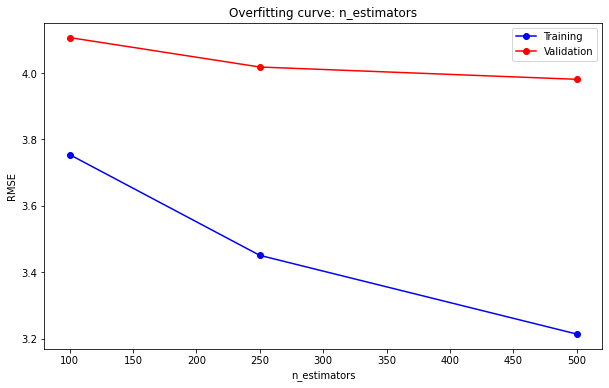

In [208]:
%%time
test_param_and_plot(XGBRegressor, 'n_estimators', [100, 250, 500], **best_params)

In [209]:
best_params['n_estimators']=500

### Max Depth

CPU times: user 2min 10s, sys: 42 s, total: 2min 52s
Wall time: 26.8 s


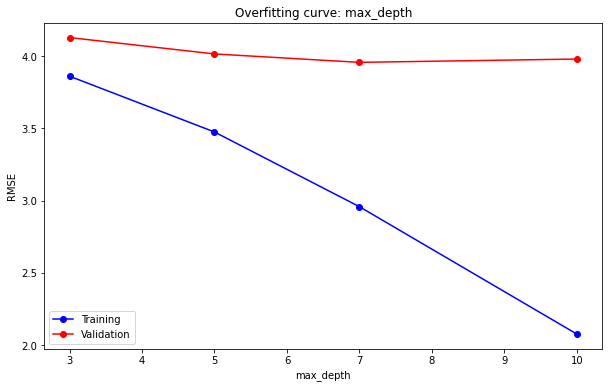

In [211]:
%%time 
test_param_and_plot(XGBRegressor, 'max_depth', [3,5,7, 10], **best_params)

In [212]:
best_params['max_depth'] = 6

### Learning Rate

CPU times: user 1min 10s, sys: 23.6 s, total: 1min 34s
Wall time: 14.5 s


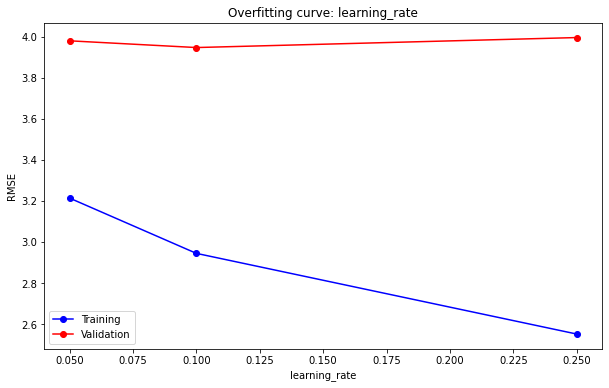

In [213]:
%%time
test_param_and_plot(XGBRegressor, 'learning_rate', [0.05, 0.1, 0.25], **best_params)

In [214]:
best_params['learning_rate'] = 0.07

### Other Parameters 
One can do test with other params. But for now we will be taking the final model with these parameters

In [215]:
xgb_model_final = XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42,
                               n_estimators=500, max_depth=7, learning_rate=0.07, 
                               subsample=0.8, colsample_bytree=0.8)

In [216]:
xgb_model_final.fit(train_inputs, train_targets)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.07, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [217]:
evaluate(xgb_model_final)

(2.7988472,
 3.9700415,
 array([ 6.7831335,  8.684079 ,  9.837443 , ..., 11.8625965,  9.514644 ,
        10.022323 ], dtype=float32),
 array([14.90214  ,  5.7477536, 48.34682  , ...,  8.009051 , 30.741354 ,
         8.837914 ], dtype=float32))

In [219]:
predict_and_submit(xgb_model_final, test_inputs, 'xgb_tuned_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.741094
1,2015-01-27 13:08:24.0000003,10.897191
2,2011-10-08 11:53:44.0000002,4.837314
3,2012-12-01 21:12:12.0000002,9.047895
4,2012-12-01 21:12:12.0000003,15.837242
...,...,...
9909,2015-05-10 12:37:51.0000002,8.962548
9910,2015-01-12 17:05:51.0000001,11.617980
9911,2015-04-19 20:44:15.0000001,54.804970
9912,2015-01-31 01:05:19.0000005,19.252716



### Putting everything together (using 20% of data)

In [223]:
%%time
sample_frac = 0.1


selected_cols = 'fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count'.split(',')
dtypes = {
    'fare_amount': 'float32',
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32',
    'passenger_count': 'float32'
}

def skip_row(row_idx):
    if row_idx == 0:
        return False
    return random.random() > sample_frac

random.seed(42)
df = pd.read_csv(data_dir+"/train.csv", 
                 usecols=selected_cols, 
                 dtype=dtypes, 
                 parse_dates=['pickup_datetime'], 
                 skiprows=skip_row)

CPU times: user 5min 10s, sys: 4.51 s, total: 5min 15s
Wall time: 5min 16s


In [224]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5542602 entries, 0 to 5542601
Data columns (total 7 columns):
 #   Column             Dtype              
---  ------             -----              
 0   fare_amount        float32            
 1   pickup_datetime    datetime64[ns, UTC]
 2   pickup_longitude   float32            
 3   pickup_latitude    float32            
 4   dropoff_longitude  float32            
 5   dropoff_latitude   float64            
 6   passenger_count    float32            
dtypes: datetime64[ns, UTC](1), float32(5), float64(1)
memory usage: 190.3 MB


## Test inputs:

not playing with it becasue it is exactly the same as before 

## 3. Prepare Dataset for Training

- Split Training & Validation Set
- Fill/Remove Missing Values
- Extract Inputs & Outputs
   - Training
   - Validation
   - Test

In [225]:
from sklearn.model_selection import train_test_split

# CREATING VALIDATION DF
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
len(train_df), len(val_df)


# FILL AND REMOVE MISSING VALUES
train_df = train_df.dropna()
val_df = val_df.dropna()

# EXTRACT INPUTS AND COLUMNS 
input_cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']
target_col = 'fare_amount'

train_inputs = train_df[input_cols]
train_targets = train_df[target_col]

val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

#NOT WORKING WITH THE TEST_DATASETS (ALREADY PREPARED FOR THE 1% DATASETS)

In [226]:
#FEATURE ENGINEERING -- DATE PART


def add_dateparts(df, col):
    df[col + '_year'] = df[col].dt.year
    df[col + '_month'] = df[col].dt.month
    df[col + '_day'] = df[col].dt.day
    df[col + '_weekday'] = df[col].dt.weekday
    df[col + '_hour'] = df[col].dt.hour
    
add_dateparts(train_df, 'pickup_datetime')
add_dateparts(val_df, 'pickup_datetime')

In [227]:
#FEATURE ENGINEERING -- DISTANCE BETWEEN PICKUP AND DROPUP USING HAVERSINE FORMULA
import numpy as np

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [228]:
def add_trip_distance(df):
    df['trip_distance'] = haversine_np(df['pickup_longitude'], df['pickup_latitude'], df['dropoff_longitude'], df['dropoff_latitude'])
    
add_trip_distance(train_df)
add_trip_distance(val_df)

In [231]:
#FEATURE ENGINEERING -- ADDING DISTANCE FROM POPULAR LANDMARK

jfk_lonlat = -73.7781, 40.6413
lga_lonlat = -73.8740, 40.7769
ewr_lonlat = -74.1745, 40.6895
met_lonlat = -73.9632, 40.7794
wtc_lonlat = -74.0099, 40.7126

def add_landmark_dropoff_distance(df, landmark_name, landmark_lonlat):
    lon, lat = landmark_lonlat
    df[landmark_name + '_drop_distance'] = haversine_np(lon, lat, df['dropoff_longitude'], df['dropoff_latitude'])
    
for a_df in [train_df, val_df]:
    for name, lonlat in [('jfk', jfk_lonlat), ('lga', lga_lonlat), ('ewr', ewr_lonlat), ('met', met_lonlat), ('wtc', wtc_lonlat)]:
        add_landmark_dropoff_distance(a_df, name, lonlat)

In [233]:
# REMOVE OUTLIERS AND INVALID DATA
def remove_outliers(df):
    return df[(df['fare_amount'] >= 1.) & 
              (df['fare_amount'] <= 500.) &
              (df['pickup_longitude'] >= -75) & 
              (df['pickup_longitude'] <= -72) & 
              (df['dropoff_longitude'] >= -75) & 
              (df['dropoff_longitude'] <= -72) & 
              (df['pickup_latitude'] >= 40) & 
              (df['pickup_latitude'] <= 42) & 
              (df['dropoff_latitude'] >=40) & 
              (df['dropoff_latitude'] <= 42) & 
              (df['passenger_count'] >= 1) & 
              (df['passenger_count'] <= 6)]

train_df = remove_outliers(train_df)
val_df = remove_outliers(val_df)

In [236]:
#SAVING INTERMEDIATE FILES TO PARQUET IN ORDER TO AVOID THE ABOVE STEPS FROM HEREON
train_df.to_parquet('train.parquet')
val_df.to_parquet('val.parquet')


def evaluate(model):
    train_preds = model.predict(train_inputs)
    train_rmse = rmse(train_targets, train_preds)
    val_preds = model.predict(val_inputs)
    val_rmse = rmse(val_targets, val_preds)
    return train_rmse, val_rmse, train_preds, val_preds

def predict_and_submit(model, test_inputs, fname):
    test_preds = model.predict(test_inputs)
    sub_df = pd.read_csv(data_dir+'/sample_submission.csv')
    sub_df['fare_amount'] = test_preds
    sub_df.to_csv(fname, index=None)
    return sub_df


In [242]:
input_cols = ['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_datetime_year', 'pickup_datetime_month', 'pickup_datetime_day',
       'pickup_datetime_weekday', 'pickup_datetime_hour', 'trip_distance',
       'jfk_drop_distance', 'lga_drop_distance', 'ewr_drop_distance',
       'met_drop_distance', 'wtc_drop_distance']

target_col = 'fare_amount'

train_inputs = train_df[input_cols]
train_targets = train_df[target_col]

val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

In [243]:
#USING THE XGBREGRESSOR (THE BEST MODEL WITH HYPERPARAMETER TUNING THAT WE COULD OBTAIN WITH 1% DATASET)
xgb_model_final = XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42,
                               n_estimators=500, max_depth=7, learning_rate=0.07, 
                               subsample=0.8, colsample_bytree=0.8)

In [244]:
xgb_model_final.fit(train_inputs, train_targets)

evaluate(xgb_model_final)

predict_and_submit(xgb_model_final, test_inputs, 'xgb_tuned_submission_10percentdata.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.313683
1,2015-01-27 13:08:24.0000003,10.630018
2,2011-10-08 11:53:44.0000002,4.596956
3,2012-12-01 21:12:12.0000002,8.944301
4,2012-12-01 21:12:12.0000003,16.242479
...,...,...
9909,2015-05-10 12:37:51.0000002,8.793513
9910,2015-01-12 17:05:51.0000001,11.660837
9911,2015-04-19 20:44:15.0000001,53.989948
9912,2015-01-31 01:05:19.0000005,19.552019


In [247]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "pragyakiran03041996/lesson7" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/pragyakiran03041996/lesson7


'https://jovian.com/pragyakiran03041996/lesson7'

With 10% data, we are in top 22% of the leaderboard

##  Train on GPU with entire dataset (Optional)

Steps:
- Install `dask`, `cudf` and `cuml`
- Load the dataset to GPU
- Create training and validation set
- Perform feature engineering
- Train XGBoost `cuml` model
- Make predictions & submit

Follow these guides:
- https://towardsdatascience.com/nyc-taxi-fare-prediction-605159aa9c24
- https://jovian.ai/allenkong221/nyc-taxi-fare-rapids-dask-gpu/v/1?utm_source=embed#C10


## References

* Dataset: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview
* Missing semester (Shell scripting): https://missing.csail.mit.edu/
* Opendatsets library: https://github.com/JovianML/opendatasets 
* EDA project from scratch: https://www.youtube.com/watch?v=kLDTbavcmd0
* GeoPy: https://geopy.readthedocs.io/en/stable/#module-geopy.distance 
* Blog post by Allen Kong: https://towardsdatascience.com/nyc-taxi-fare-prediction-605159aa9c24 
* Machine Learning with Python: Zero to GBMs - https://zerotogbms.com 
* Experiment tracking spreadsheet: https://bit.ly/mltrackingsheet 
* Pandas datetime components: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#time-date-components 
* Haversine distance: https://en.wikipedia.org/wiki/Haversine_formula 
* Haversine distance with Numpy: https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas 
* RAPIDS (parent project for cudf and cuml): https://rapids.ai/
* Data Science blog post from scratch: https://www.youtube.com/watch?v=NK6UYg3-Bxs 
* Examples of Machine Learning Projects:
    * Walmart Store Sales: https://jovian.ai/anushree-k/final-walmart-simple-rf-gbm
    * Used Car Price Prediction: https://jovian.ai/kara-mounir/used-cars-prices 
    * Lithology Prediction: https://jovian.ai/ramysaleem/ml-project-machine-predicting-lithologies
    * Ad Demand Prediction: https://jovian.ai/deepa-sarojam/online-ad-demand-prediction-ml-prj 


In [248]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "pragyakiran03041996/lesson7" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/pragyakiran03041996/lesson7


'https://jovian.com/pragyakiran03041996/lesson7'